# Introduction to Latent Semantic Analysis

Written by Benjamin Caruso

Notebook based on the following paper: http://lsa.colorado.edu/papers/dp1.LSAintro.pdf by researchers in the Department of Psychology at the University of Colorado, Boulder, 1998.

In [108]:
import numpy as np
import pandas as pd

import scipy.stats
from scipy import spatial
from numpy.linalg import eig

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

Latent Semantic Analysis (LSA) is a method of obtaining the similarity of meaning of words within a large series of texts using pure linear algebra. Every word or set of words is transformed as a point in a very high dimensional vector space. LSA, while related to neural network models, is actually based on singular value decomposition, which breaks the BOW matrix down into three distinct matrices, each containing information that when combined via dot product, builds the original matrix. Many simulation results using LSA compare to human cognition results, implying that LSA does a successful job of capturing the semantics of words and passages within a corpus.

### Bag of Words Initialization

In [111]:
# Example of text data: titles of NLP and health/exercise research papers - research papers on disjoint topics

# Paper titles found from paperswithcode.com and nih website

# Exercise and health related titles
n1 = 'Damage to Skeletal Muscle from Eccentric Exercise'
n2 = 'High-Intensity Interval Training to Maximize Cardiac Benefits of Exercise Training'
n3 = 'Exercise Enhances and Protects Brain Function'
n4 = 'Skeletal Muscle Hypertrophy After Aerobic Exercise Training'
n5 = 'Training-Induced Changes in Neural Function'

# NLP related titles
t1 = 'Parameter-Efficient Transfer Learning for NLP'
t2 = 'Recurrent Attention Network on Memory for Aspect Sentiment Analysis'
t3 = 'Bag of Tricks for Efficient Text Classification'
t4 = 'SKEP: Sentiment Knowledge Enhanced Pre-training for Sentiment Analysis'
t5 = 'Interactive Attention Networks for Aspect Level Sentiment Classification'
t6 = 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks'

# Define entire corpus as set of all titles
corpus = [n1, n2, n3, n4, n5, t1, t2, t3, t4, t5, t6]
# Used for dataframe index
corpus_map = ['n1', 'n2', 'n3', 'n4', 'n5', 't1', 't2', 't3', 't4', 't5', 't6']

In [112]:
# List of vocabulary over entire corpus, with repeats
vocab = [word for sentence in corpus for word in sentence.split(' ')]
# Obtain list of unqiue words within vocab
unique_words = list(set(vocab))

# See first 5 words
unique_words[:5]

['Enhances', 'Muscle', 'Training-Induced', 'Analysis', 'Training']

In [113]:
# Map each word to empty list for bag-of-words dictionary 
bow = {word: [] for word in unique_words}

for word in unique_words:
    for sentence in corpus:
        # For every unique word, we look at each sentence
        sentence_words = sentence.split()
        
        # Obtain number of times word appears in sentence
        sum_word = 0
        for w in sentence_words:
            sum_word += (word == w)
        
        # Add word count word count vector
        bow[word].append(sum_word)
        
    # Only keep words that appear in at least 2 sentences
    if sum(bow[word]) < 2:
        del bow[word]   

# Convert to dataframe and get matrix
bow_df = pd.DataFrame(bow)
bow_mat = bow_df.values
# Save column names - words that associate with each column
columns = list(bow_df.columns)
bow_df.index = corpus_map
bow_df

,Muscle,Analysis,Training,Exercise,for,Sentiment,Classification,Aspect,to,NLP,Function,of,Attention,Skeletal
n1,1,0,0,1,0,0,0,0,1,0,0,0,0,1
n2,0,0,2,1,0,0,0,0,1,0,0,1,0,0
n3,0,0,0,1,0,0,0,0,0,0,1,0,0,0
n4,1,0,1,1,0,0,0,0,0,0,0,0,0,1
n5,0,0,0,0,0,0,0,0,0,0,1,0,0,0
t1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
t2,0,1,0,0,1,1,0,1,0,0,0,0,1,0
t3,0,0,0,0,1,0,1,0,0,0,0,1,0,0
t4,0,1,0,0,1,2,0,0,0,0,0,0,0,0
t5,0,0,0,0,1,1,1,1,0,0,0,0,1,0


Here we result in a bag of words matrix. This is the matrix that LSA will perform SVD on to determine the most important correlations.

### Singular Value Decomposition

In [114]:
# Obtain SVD
U, S, V = np.linalg.svd(bow_mat)

# Define sigma matrix as same size as A with sigma values on the diagonal
sigma = np.zeros(bow_mat.shape)

# Check if n or p is greater
# Want to use the smaller index to assign the diagonals
if bow_mat.shape[1] > bow_mat.shape[0]:
    sigma[:bow_mat.shape[0], :bow_mat.shape[0]] = np.diag(S)
else:
    sigma[:bow_mat.shape[1], :bow_mat.shape[1]] = np.diag(S)

# Now recreate matrix using new approximation - zeros are represented as tiny numbers
#print(U @ sigma @ V)


In [115]:
# Obtain first two columns of each matix
V2 = V[:,:2]
S2 = sigma[:2,:2]
U2 = U[:,:2]

In [116]:
# Correlation matrix using two dimensions
corr = (U2 @ S2 @ V2.T)
corr_df = pd.DataFrame(corr)

# Round values to 2 decimal points
corr_df = corr_df.apply(lambda x: round(x, 2))

# Assign indices that represent which text refers to which row
corr_df.index = corpus_map
# Assign column names which match the BOW columns
corr_df.columns = columns

corr_df

,Muscle,Analysis,Training,Exercise,for,Sentiment,Classification,Aspect,to,NLP,Function,of,Attention,Skeletal
n1,0.44,-0.02,-0.39,-0.24,-0.40,-0.00,0.02,-0.17,-0.93,-0.05,-0.23,0.75,-0.34,-0.18
n2,0.67,-0.01,-0.63,-0.34,-0.61,-0.02,0.04,-0.24,-1.44,-0.05,-0.34,1.14,-0.52,-0.34
n3,0.18,-0.01,-0.16,-0.10,-0.17,-0.00,0.01,-0.07,-0.39,-0.02,-0.09,0.31,-0.14,-0.08
n4,0.51,-0.02,-0.46,-0.28,-0.46,-0.00,0.02,-0.19,-1.08,-0.05,-0.26,0.87,-0.39,-0.22
n5,0.02,-0.00,-0.02,-0.01,-0.02,0.00,0.00,-0.01,-0.04,-0.00,-0.01,0.03,-0.01,-0.01
t1,-0.00,0.21,-0.20,0.25,0.08,-0.16,0.08,0.11,-0.07,0.18,0.05,-0.12,0.03,-0.48
t2,-0.02,0.60,-0.58,0.75,0.25,-0.47,0.25,0.33,-0.18,0.54,0.17,-0.38,0.11,-1.40
t3,0.07,0.25,-0.32,0.27,0.03,-0.20,0.11,0.11,-0.25,0.22,0.03,-0.02,-0.02,-0.63
t4,-0.02,0.61,-0.58,0.75,0.25,-0.47,0.25,0.33,-0.18,0.54,0.17,-0.38,0.12,-1.41
t5,-0.01,0.58,-0.56,0.71,0.23,-0.45,0.24,0.31,-0.19,0.51,0.16,-0.35,0.10,-1.34


### Comparing Cosine Similarities and Correlations Among Words and Passages

In [125]:
rval, pval = scipy.stats.pearsonr(corr_df['Exercise'], corr_df['Function'])

print(f"Pearson r(exercise.function): {round(rval, 2)} with p-value {round(pval,4)}")

rval, pval = scipy.stats.pearsonr(corr_df['Exercise'], corr_df['Sentiment'])

print(f"Pearson r(exercise.sentiment): {round(rval, 2)} with p-value {round(pval,4)}")

print(f"Value of NLP at document t4: {corr_df['NLP']['t4']}")

Pearson r(exercise.function): 0.95 with p-value 0.0
Pearson r(exercise.sentiment): -0.97 with p-value 0.0
Value of NLP at document t4: 0.54


SVD on this basic example was able to extract common similarities using only two dimensions of the decomposed matrices. By looking at the r value for 'exercise' with "function" and "sentiment", we see very different correlations which makes sense since "function" appears in many documents with "exercise" while "sentiment" is associated with a different set of research article titles.

Furthermore, and more interestingly, if we look at the NLP vector within the correlation dataframe, we can see that for titles in the NLP set, the word/term NLP is likely to be seen *even in passages that do not include the term NLP*. SVD is able to understand the context that the term NLP is used well enough to extrapolate that NLP likely belongs in a title related to it, still using only two dimensions of interest to make this conclusion. In my toy example, the value of NLP at document t4 is 0.54, implying that NLP would likely be seen 54% of the time that passage t4 appears. t4 refers to the title 'SKEP: Sentiment Knowledge Enhanced Pre-training for Sentiment Analysis', which does not have the term 'NLP' within it.

In [126]:
print(f"Correlation of vectors n1 and n2: {1 - spatial.distance.cosine(corr_df.values[0], corr_df.values[1])}")
print(f"Correlation of vectors t9 and t10: {1 - spatial.distance.cosine(corr_df.values[5], corr_df.values[6])}")
print(f"Correlation of vectors n1 and t10: {1 - spatial.distance.cosine(corr_df.values[0], corr_df.values[10])}")

Correlation of vectors n1 and n2: 0.9992034197871356
Correlation of vectors t9 and t10: 0.9995072827097518
Correlation of vectors n1 and t10: -0.0043438117129521725


When the passage vectors (vectors of each word's correlation with the vector as a whole) are compared, passages that came from the same subgroup of research titles (NLP and exercise/health) are highly correlated, while passages that are in different subgroups are not correlated whatsoever. In the example shown, vector cosine distance from each of the groups are calculated, and then the cosine distance of vector n1 and t10, in different subgroups, is calculated to be far lower. Each distance was subtracted by 1 to get the similarity measure of the vectors. Although a trivial example, it clearly shows how LSA, through singular value decomposition of a bag-of-words term frequency matrix, has captured some of the similarity between certain passages and words.

### Plotting PCA Representations

In [30]:
# Obtain word vectors from correlation dataframe 
word_vecs = []
for col in columns:
    word_vecs.append((corr_df[col].values, col))
word_vectors = [vec[0] for vec in word_vecs]

''

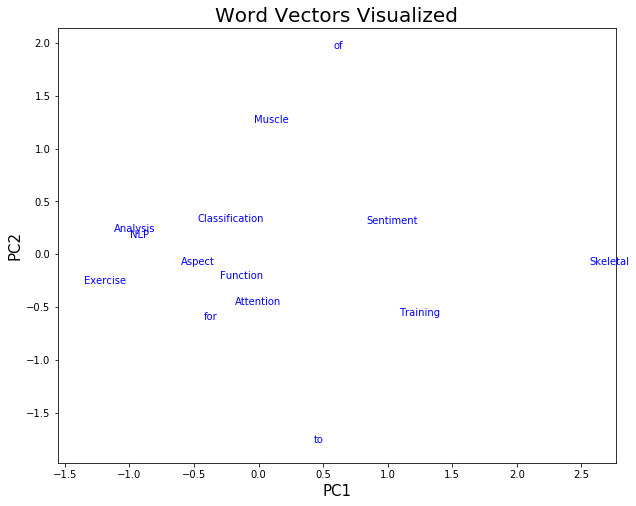

In [110]:
# Use PCA to plot the word vectors in two dimensions
two_d_rep = PCA(n_components = 2).fit_transform(corr_df.T)

# Define x and y coordinates from the PCA transformation
x = [coord[0] for coord in two_d_rep]
y = [coord[1] for coord in two_d_rep]

plt.figure(figsize=(10, 8))

# Define vocab and annotate each point with name
for i, word in enumerate(corr_df.columns):
    plt.annotate(str(word), xy = (x[i],y[i]), color = 'Blue')

# Set labels and title
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Vectors Visualized",size=20)
plt.scatter(x, y, c = 'None')

;

### Same Plot using V from SVD

''

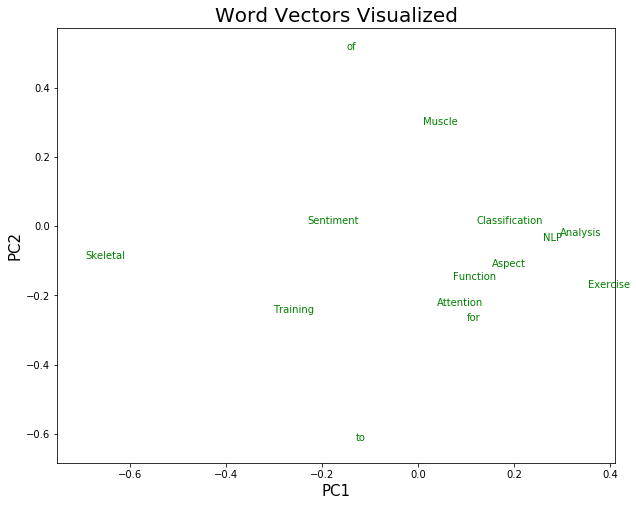

In [105]:
# Use V2 from SVD to plot the word vectors in two dimensions
#two_d_rep = PCA(n_components = 2).fit_transform(corr_df.T)

# Define x and y coordinates from the PCA transformation
x = [coord[0] for coord in V2]
y = [coord[1] for coord in V2]

plt.figure(figsize=(10, 8))

# Define vocab and annotate each point with name
for i, word in enumerate(corr_df.columns):
    plt.annotate(str(word), xy = (x[i],y[i]), color = 'Green')

# Set labels and title
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Vectors Visualized",size=20)
plt.scatter(x, y, c = 'None')

;

The similarities between these plots indicate how PCA uses SVD to perform its dimensionality reduction. The plots seem to cluster 'classification', 'NLP', 'Analysis', and 'Aspect' together which makes sense, but oddly enough other wordsl like 'Function' and 'Exercise' appear nearby despite being in different titles. The likely explanation is that the trivially small dataset used did not allow for enough distinction between the different words.